### Load packages

In [5]:
%matplotlib inline

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser

### Connect to the datacube

In [6]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters

In [7]:
# Define your period of interest
year = 2015
time = (str(year))

res_x = 25
res_y = -25

In [8]:
location = 'KI'
min_x = 360600
max_x = 551200
min_y = -3945800
max_y = -3716500

location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

location = 'Murray Valley'
min_x = 1100000
max_x = 1200000
min_y = -4000000
max_y = -3900000

### View the selected location

In [32]:
# Set the central latitude and longitude
central_lat = -42.827936 
central_lon = 145.673772

# Set the buffer to load around the central coordinates
buffer = 0.5

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

## Load WOFL data


To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [33]:
# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2015-01-01','2015-12-31'),
#     "crs": "EPSG:4326",
#     "output_crs": "EPSG:3577",
    "resolution": (-100, 100),
#     "group_by": "solar_day"
}

In [34]:
# Load the data from the datacube
fc = dc.load(product="ls8_fc_albers", **query)
fc

<xarray.Dataset>
Dimensions:      (time: 110, x: 954, y: 1162)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T00:04:40 ... 2015-12-27T23:58:59.500000
  * y            (y) float64 -4.685e+06 -4.685e+06 ... -4.801e+06 -4.801e+06
  * x            (x) float64 1.103e+06 1.103e+06 ... 1.198e+06 1.198e+06
    spatial_ref  int32 3577
Data variables:
    BS           (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    PV           (time, y, x) int16 3 2 2 2 1 2 2 2 ... 20 18 19 20 20 21 21 22
    NPV          (time, y, x) int16 99 99 99 100 100 99 99 ... 68 68 75 73 72 71
    UE           (time, y, x) int16 8 8 8 7 7 7 8 7 7 7 ... 3 3 3 3 3 3 3 3 3 3
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

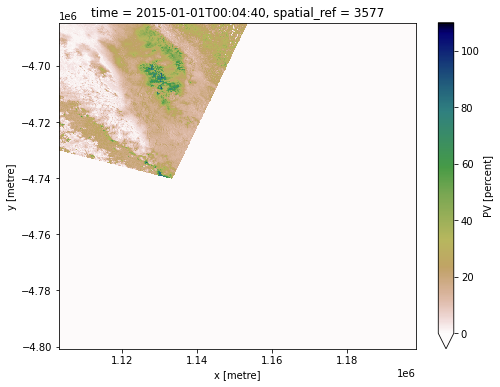

In [43]:
# Visualise an example tile
fc1 = fc.isel(time=0)
fc1.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6),vmin=0, vmax=110)
plt.show()

In [59]:
pv0 = fc.PV>0
pv0

<xarray.DataArray 'PV' (time: 110, y: 1162, x: 954)>
array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T00:04:40 ... 2015-12-27T23:58:59.500000
  * y            (y) float64 -4.685e+06 -4.685e+06 ... -4.801e+06 -4.801e+06
  * x            (x) float64 1.103e+06 1.103e+06 ... 1.198e+06 1.198e+06
    spatial_ref  int32 3577

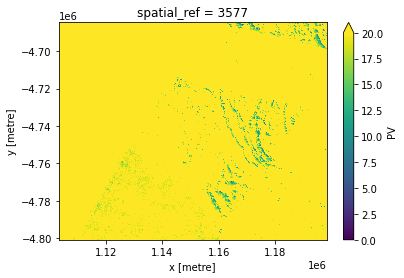

In [61]:
count = pv0.sum(dim='time')
count.plot(vmin=0, vmax=20)

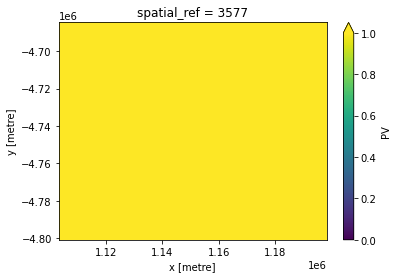

### Export out tif

In [77]:
# Export PV to GeoTIFF
fc_PV_PC_50 = fc.PV_PC_50.isel(time=0).to_dataset(name='PV_PC_50')
write_geotiff(f'{location}_{year}_PV_PC_50.tif', fc_PV_PC_50)

# Export NPV to GeoTIFF
fc_NPV_PC_50 = fc.NPV_PC_50.isel(time=0).to_dataset(name='NPV_PC_50')
write_geotiff(f'{location}_{year}_NPV_PC_50.tif', fc_NPV_PC_50)